# Less is more: Free marketing for Apple
# Project Milestone 2 Notebook

This notebook contains code to analyze data of videos about smartphone brands. It contains Pipeline to Load, Clean and Analyze the data.

### Imports

In [141]:
import os
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import wordnet as wn
import string 
from functools import partial

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot

# Instead of multiprocessing because of IPython support
import multiprocess as mp

### File Paths

In [51]:
BASE_PATH = "."    # Change this to run in colab

RAW_DATA_FOLDER = "data"
MODIFIED_DATA_FOLDER = "generated"
TEMPORARY_DATA_FOLDER = "temp"
IMAGES_FOLDER = "images"

VIDEOS_METADATA_FILE = 'yt_metadata_en.jsonl.gz'
TECH_CATEGORY_FILE = 'science_and_technology_videos.csv'
SMARTPHONES_DATA = "Phone_to_Smartphone.csv"
VIDEOS_BRANDS_DATA = "videos_with_brands.csv.gz" # Generated with brand_detection.py

### Constants

In [31]:
VIDEOS_METADATA_COLUMNS = ["categories", "channel_id", 
                           "crawl_date", "description", 
                           "dislike_count", "display_id", 
                           "duration", "like_count", "tags", 
                           "title", "upload_date", "view_count"]

CATEGORY = 'Science & Technology'
CHUNK_SIZE = 500_000

MONTHS_NAMES = ["January", "February", "March", 
                "April", "May", "June", "July", 
                "August", "September", "October", 
                "November", "December"]

BRANDS_TO_ANALYZE = ["Samsung", "Apple", "Huawei", "Xiaomi", "Oppo", ]

## Videos Filtering

### Read Raw Data

We load the original raw data. This must be done by chuncks because the dataset is too large to be loaded at once.

In [4]:
%%time
raw_data_reader = pd.read_json(os.path.join(BASE_PATH, RAW_DATA_FOLDER, VIDEOS_METADATA_FILE), 
                           compression="infer", chunksize=CHUNK_SIZE, lines=True)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


### Extract Tech and Science Videos

In order to reduce the number of irrelevant videos in our dataframe , and additionally reduce the size of the dataset, we filter out all the videos that are not in the 'Science & Technology' category. The resulting dataframe is saved in another csv file.

In [5]:
%%time
for data_chunk in tqdm(raw_data_reader):
    tech_videos = data_chunk[data_chunk.categories == CATEGORY]
    tech_videos.to_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, TECH_CATEGORY_FILE), 
                      mode='a', header=False, columns = VIDEOS_METADATA_COLUMNS)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


### Load Tech & Science Videos Data

We load the csv file created at the preceeding step and inspect its columns as well as its first rows.

In [10]:
processed_data_reader = pd.read_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, TECH_CATEGORY_FILE), 
                                    names=VIDEOS_METADATA_COLUMNS)

In [11]:
processed_data_reader.columns

Index(['categories', 'channel_id', 'crawl_date', 'description',
       'dislike_count', 'display_id', 'duration', 'like_count', 'tags',
       'title', 'upload_date', 'view_count'],
      dtype='object')

In [12]:
processed_data_reader.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
3968,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:31.549534,Climate change threatens to make dry regions e...,503.0,XPSYzLZ7xKU,200,15328.0,"seeker,science,curiosity,education,explain,lea...",Transforming Air Into Pure Drinking Water Is F...,2019-10-03 00:00:00,357909.0
3969,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:32.224556,We now have a new understanding of the undergr...,84.0,WWD_1Nq6iwQ,308,6498.0,"seeker,science,curiosity,education,explain,lea...",This Underground Economy Exists in a Secret Fu...,2019-10-02 00:00:00,151492.0
3970,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:32.905550,Glaucoma is one of the leading causes of blind...,36.0,0U1rkFraBQo,399,2723.0,"SICK,science,health,health news,health tech,te...",How Does Glaucoma Cause Vision Loss?,2019-10-01 00:00:00,63057.0
3971,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:33.614600,NASA and Arizona State University plan to send...,111.0,NMknT8vKOL8,292,5274.0,"NASA,Arizona State University,asteroid,asteroi...",This Metal Asteroid Could Reveal Secrets About...,2019-09-30 00:00:00,229530.0
3972,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:34.300370,An international team of scientists and engine...,156.0,s0P9hj1R_Zw,486,10025.0,"focal point,documentary,interview,short doc,sc...","The International Hunt for Dark Energy Is On, ...",2019-09-29 00:00:00,322653.0


### Check and Clean Data

We first check that the number of dislikes and the number of likes are either both defined or both  undefined in order to make sure the following analysis will be possible. After that, we clean the tags and description columns by replacing the Nan values by empty strings.

In [13]:
(processed_data_reader.dislike_count.isna() == processed_data_reader.like_count.isna()).sum() == len(processed_data_reader)

True

In [14]:
processed_data_reader.tags.replace(np.nan, "", inplace=True)
processed_data_reader.description.replace(np.nan, "", inplace=True)

## Utility Functions

In [64]:
def string_to_set(x) :
    return (eval(x.title_brands),
            eval(x.description_brands),
            eval(x.tags_brands),
            eval(x.union))

In [4]:
def capture_year(string):
    """
    Returns the Year by matching the string with a regular Expression.
    
    Arguments:
        string (string): Any string that might or might not contain 4 consecutive numbers representing year
        
    returns:
        int: 4 digit integer representing the year.
    """
    year = re.search('([0-9]{4})',string)
    if year:
        return int(year.group(0))
    else:
        return -1

In [5]:
def get_brand_models(brand_name, df):
    """
    Returns a subset of the original dataframe corresponding
    only to the videos that mention the given brand.
    
    arguments:
            brand_name (string) : the name of the brand the 
                video retrieved should mention
            df (pandas.DataFrame) : a preprocessed dataframe
                containing as rows the videos as well as their
                associated brands
    returns:
            A dataframe containing only the videos the mention
            the brand passes as parameter
    """
    return df[df.Brand == brand_name].Name.unique()

In [6]:
def find_brand(brand_models, row):
    """
    Returns a list containing all of the brands, among the ones
    contained in brand_models.keys(), which have at least one 
    model that is mentioned in the textual fields of the given
    video. The textual fields searched are the title, the 
    description and the tags of the video.
    
    arguments:
            row (pandas.Series) : a row of the dataset that contain
                    the metadata realted to a video.
            brand_models (dict) : a dictionary containing as keys
                    the brands names and as values a list containing
                    all the models released by this brand.
    returns : 
            A list containing the brands that matched according 
            to the brand_models dictionary
    """
    brands_mentioned = []
    for brand in brand_models.keys():
        for model in brand_models[brand]:
            model = model.lower()
            if (model in row.title.lower()
                or (model in row.description.lower())
                or model in row.tags.lower()):
                brands_mentioned.append(brand)
                break
    if len(brands_mentioned) == 0:
        return None
    return brands_mentioned

In [7]:
def calc_release(row, months):
    """
    This function parses the string containing a date in ambiguous format. 
    It tries to parse it using regular expressions and returns a date with the most precision it can get.
    
    arguments:
            row (pandas.Series) : a row of the dataset that contain
                    the metadata realted to a video.
            months (List) : A list containing anmes of the 12 months
            
    returns:
            pandas.DateTime : DateTime object containing the date
    """
    year = row.released_year
    release = re.sub(r"\s*Released\s*", "", row.released_at, flags=re.IGNORECASE)
    
    full_date = re.search(r"[0-9]{4}, [a-z]+\s[0-9]{2}", release, flags=re.IGNORECASE)
    quarters_date = re.search(r"[0-9]{4}, [A-Z][1-4]", release, flags=re.IGNORECASE)
    months_date = re.search(r"[0-9]{4}, [a-z]+", release, flags=re.IGNORECASE)
    years_date = re.search(r"[0-9]{4}", release)
    
    if full_date:
        return pd.to_datetime(full_date.group(0))
    elif quarters_date:
        q = int(quarters_date.group(0)[-1])
        m = months[(q-1)*3 + 1]
        return pd.to_datetime("{}/{}".format(m, year))
    elif months_date:
        return pd.to_datetime(months_date.group(0))
    elif years_date:
        return pd.to_datetime(years_date.group(0))
    else:
        return None

In [8]:
def get_plot(brands, column_name, aggregation, brand_videos, figsize=(20, 10), title="", x_label="", y_label="", interval="QS", whole_data=None) : 
    """
    For each brand contained in the 'brands' list, this function retrieves
    the corresponding time-series, groups it according to the given interval
    and computes the aggregation passed as argument. Finally, it plots the
    resulting series.
    
    arguments : 
            brands (list) : name of the brands whose data we want to plot
            column_name (str) : the name of the column of the dataframe 
                    that we want to do our computation on.
            aggregation (str) : the aggregation we want to use (e.g. 'mean')
            brand_videos (dict) : contains as keys the name of a given brand
                    and as values a dataframe containing only videos that
                    mention this brand. This dataframe must be indexed by
                    dates so that the .resample() function can be used on it
            figsize (tuple) : the size of the figure that will be plotted
            title (str) : the title of the plot
            x_label (str) : the label of the x axis of the plot
            y_label (str) : the label of the y axis of the plot
            interval (str) : the interval on which to aggregate the data
                    to compute the desired aggregation.
            whole_data (pandas.DataFrame) : contains all of the videos
                    without separating them by brand. This is None by default. 
                    If a dataframe is passed, the aggregation will also be 
                    computed on it and plotted alongside the plots of the 
                    brands.
    """
    fig = plt.figure(figsize=figsize, dpi=80)
    
    for idx, brand in enumerate(brands):
        
        if brand != "Oppo":
            df = brand_videos[brand]

            #computing the mean per mont
            mean_views = df[column_name].resample(interval).agg(aggregation)
            mean_views[mean_views.isna()] = 0      # months where no video appear should have mean zero

            #plotting
            plt.plot(mean_views, label=brand, lw=3)
            #sns.lineplot(data=df[column_name], estimator=aggregation, label=brand, lw=3)#, x="upload_date", y=mean_views)

    #plotting the overall statistic
    if whole_data is not None:
        global_statistic = whole_data[column_name].resample(interval).agg(aggregation)
        global_statistic[global_statistic.isna()] = 0
        plt.plot(global_statistic, label="all data", lw=2, ls="--", color="grey") 
        #sns.lineplot(data=global_statisic, estimator=aggregation, label="all data", lw=2, ls="--", color="grey")


    #plt.yscale('log')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

In [9]:
def get_plot_cummulative(brands, column_name, aggregation, brand_videos, figsize=(20, 10), title="", x_label="", y_label="", interval="QS", whole_data=None) : 
    """
    For each brand contained in the 'brands' list, this function retrieves
    the corresponding time-series, groups it according to the given interval
    and computes the aggregation passed as argument but in a cumulative manner
    with respect to time. Finally, it plots the resulting series.
    
    arguments : 
            brands (list) : name of the brands whose data we want to plot
            column_name (str) : the name of the column of the dataframe 
                    that we want to do our computation on.
            aggregation (str) : the aggregation we want to use (e.g. 'mean')
            brand_videos (dict) : contains as keys the name of a given brand
                    and as values a dataframe containing only videos that
                    mention this brand. This dataframe must be indexed by
                    dates so that the .resample() function can be used on it
            figsize (tuple) : the size of the figure that will be plotted
            title (str) : the title of the plot
            x_label (str) : the label of the x axis of the plot
            y_label (str) : the label of the y axis of the plot
            interval (str) : the interval on which to aggregate the data
                    to compute the desired aggregation.
            whole_data (pandas.DataFrame) : contains all of the videos
                    without separating them by brand. This is None by default. 
                    If a dataframe is passed, the aggregation will also be 
                    computed on it and plotted alongside the plots of the 
                    brands.
    """
    fig = plt.figure(figsize=figsize, dpi=80)
    
    for idx, brand in enumerate(brands):
        
        if brand != "Oppo":
            df = brand_videos[brand]

            #computing the mean per mont
            mean_views = df[column_name].resample(interval).agg(aggregation)
            mean_views[mean_views.isna()] = 0     # months where no video appear should have mean zero
            mean_views = mean_views.cumsum()
            #plotting
            plt.plot(mean_views, label=brand, lw=3)
            #sns.lineplot(data=df[column_name], estimator=aggregation, label=brand, lw=3)#, x="upload_date", y=mean_views)

    #plotting the overall statistic
    if whole_data is not None:
        global_statistic = whole_data[column_name].resample(interval).agg(aggregation)
        global_statistic[global_statistic.isna()] = 0
        global_statistic = global_statistic.cumsum()
        plt.plot(global_statistic, label="all data", lw=2, ls="--", color="grey") 
        #sns.lineplot(data=global_statisic, estimator=aggregation, label="all data", lw=2, ls="--", color="grey")


    #plt.yscale('log')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

## Phones & Tablets Filtering

### Load data 

We load an additional dataset containing the information about the phone models released by different brands.

In [10]:
phone_models_df = pd.read_csv(os.path.join(BASE_PATH, RAW_DATA_FOLDER, SMARTPHONES_DATA))

### Processing the release Date

We process the released_year column to transform it into a datetime format and make it the index of the phone models dataframe. This will help for time-series plot we do below.

In [11]:
phone_models_df["released_year"] = phone_models_df.released_at.apply(lambda x : capture_year(str(x)))

In [12]:
# Remove unreleased/Cancelled phones
phone_models_df.drop(phone_models_df[phone_models_df["released_year"] == -1].index, axis=0, inplace=True)

In [13]:
phone_models_df["release"] = phone_models_df.apply(lambda x : calc_release(x, MONTHS_NAMES), axis=1)

In [14]:
# set the release column as the dataframe's index
phone_models_df = phone_models_df.set_index("release")

In [15]:
phone_models_df.head(5)

,id,Brand,Name,Status,coverImage,released_at,body,os,Chipset,Colors,camera_pixels,battery_size,Type,Dual,Triple,Charging,Size,Resolution,Other_specifications,released_year
release,,,,,,,,,,,,,,,,,,,,
1999-01-01,1,Nokia,Nokia 3210,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no3210b.gif,Released 1999,"151g, 22.5mm thickness",Feature phone,NaN,User exchangeable front and back covers,NO,&nbsp;,Removable Li-Ion battery,NaN,NaN,NaN,NaN,5 lines,"{""storage"":""No card slot"",""video_pixels"":""No v...",1999
1998-01-01,2,Nokia,Nokia 5110,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no5110b.gif,Released 1998,"170g, 31mm thickness",Feature phone,NaN,"Xpress-On covers, 4 basic, 7 metallic",NO,600 mAh,Removable Li-Po 600 mAh battery,NaN,NaN,NaN,NaN,5 lines,"{""storage"":""No card slot"",""video_pixels"":""No v...",1998
1998-01-01,3,Nokia,Nokia 6110,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no6110b.gif,Released 1998,"137g, 28mm thickness",Feature phone,NaN,2,NO,600 mAh,Removable Li-Po 600 mAh battery,NaN,NaN,NaN,NaN,5 lines,"{""storage"":""No card slot"",""video_pixels"":""No v...",1998
1998-01-01,4,Nokia,Nokia 6130,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no6130b.gif,Released 1998,"152g, 25mm thickness",Feature phone,NaN,2,NO,600 mAh,Removable Li-Po 600 mAh battery (BPS-1),NaN,NaN,NaN,NaN,5 lines,"{""storage"":""No card slot"",""video_pixels"":""No v...",1998
1998-01-01,5,Nokia,Nokia 6150,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no6150b.gif,Released 1998,"141g, 28mm thickness",Feature phone,NaN,2,NO,600 mAh,Removable Li-Po 600 mAh battery (BPS-1),NaN,NaN,NaN,NaN,5 lines,"{""storage"":""No card slot"",""video_pixels"":""No v...",1998


### Filter to Match timeframe with Videos

In this subsection, we disregard all models that were not released during the time interval spanned by the Youniverse data.

In [16]:
# Filter to match the range of youtube data
filtered_phones = phone_models_df[(phone_models_df["released_year"] > 2004) & (phone_models_df["released_year"] < 2020)]

In [17]:
filtered_phones.columns

Index(['id', 'Brand', 'Name', 'Status', 'coverImage', 'released_at', 'body',
       'os', 'Chipset', 'Colors', 'camera_pixels', 'battery_size', 'Type',
       'Dual', 'Triple', 'Charging', 'Size', 'Resolution',
       'Other_specifications', 'released_year'],
      dtype='object')

In [18]:
filtered_phones.head()

,id,Brand,Name,Status,coverImage,released_at,body,os,Chipset,Colors,camera_pixels,battery_size,Type,Dual,Triple,Charging,Size,Resolution,Other_specifications,released_year
release,,,,,,,,,,,,,,,,,,,,
2006-05-01,803,Samsung,Samsung E500,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/sse500.gif,"Released 2006, May","77g, 21.9mm thickness",Feature phone,NaN,NaN,1.3 MP,800 mAh,Removable Li-Ion 800 mAh battery,NaN,NaN,NaN,"1.76 inches, 9.7 cm2 (~25.8% screen-to-body ra...",176 x 220 pixels (~160 ppi density),"{""storage"":""60MB storage, no card slot"",""video...",2006
2005-02-01,969,Panasonic,Panasonic X800,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/pax800.gif,"Released 2005, Q1","99g, 17mm thickness","Symbian OS 7.0s, Series 60 v2.0 UI",NaN,NaN,0.3 MP,720 mAh,Removable Li-Ion 720 mAh battery,NaN,NaN,NaN,"2.2 inches, 36 x 43 mm, 15.4 cm2 (~32.1% scree...",176 x 208 pixels (~124 ppi density),"{""storage"":""8MB storage, miniSD slot"",""video_p...",2005
2005-02-01,972,Nokia,Nokia 6822,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/no6822.gif,"Released 2005, Q1","100g, 21mm thickness",Feature phone,NaN,NaN,0.3 MP,850 mAh,Removable Li-Ion 850 mAh battery (BL-5C),NaN,NaN,NaN,"1.5 inches, 7.3 cm2 (~14.9% screen-to-body ratio)","128 x 128 pixels, 8 lines, 1:1 ratio (~121 ppi...","{""storage"":""3.5MB storage, no card slot"",""vide...",2005
2005-02-01,973,LG,LG F2300,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/lgf2300.gif,"Released 2005, Q1","91g, 24mm thickness",Feature phone,NaN,NaN,0.3 MP,1000 mAh,Removable Li-Ion 1000 mAh battery,NaN,NaN,NaN,NaN,"128 x 160 pixels, 7 lines","{""storage"":""3.5MB storage, no card slot"",""vide...",2005
2005-02-01,974,LG,LG G1610,Discontinued,https://fdn2.gsmarena.com/vv/bigpic/lgg1610.gif,"Released 2005, Q1","83g, 17mm thickness",Feature phone,NaN,NaN,NO,950 mAh,Removable Li-Ion 950 mAh battery,NaN,NaN,NaN,"1.5 inches, 7.3 cm2 (~15.9% screen-to-body ratio)","128 x 128 pixels, 1:1 ratio (~121 ppi density)","{""storage"":""1.1MB storage, no card slot"",""vide...",2005


## Analysis of Phone Models

### Show Brands with most Phones

We show a plot of the number of models released by the brands that we have in our dataset. We limit the plot to the top 10 brands in term of number of models.

In [45]:
fig_1 = px.bar(filtered_phones.groupby("Brand").count()["id"].sort_values().tail(10).rename("Models"), orientation="h", title="Brands with most phone models")
fig_1.update_layout(xaxis_title="Count", title_x=0.5, showlegend=False)
fig_1.layout.xaxis.fixedrange = True
fig_1.layout.yaxis.fixedrange = True
fig_1

### Show models of Brands that we chose

We show a plot of the number of models released by the brands that we chose for our analysis based on highest market share in 2019.

In [46]:
fig_2 = px.bar(filtered_phones[filtered_phones.Brand.apply(lambda x : x in BRANDS_TO_ANALYZE)].groupby("Brand").count()["id"].sort_values().rename("Models"), orientation="h", title="Brands with most phone models")
fig_2.update_layout(xaxis_title="Count", title_x=0.5, showlegend=False)
fig_2.layout.xaxis.fixedrange = True
fig_2.layout.yaxis.fixedrange = True
fig_2

In [47]:
html = plot(fig_1, output_type='div', include_plotlyjs=False)
with open("./exported_plots/smartphone_plot_most_models.js", "w") as f:
    f.write(html)

html = plot(fig_2, output_type='div', include_plotlyjs=False)
with open("./exported_plots/smartphone_plot_analyzed_brands.js", "w") as f:
    f.write(html)

## Clean Videos by Brand Data

In [85]:
branded_videos = pd.read_csv(os.path.join(BASE_PATH, MODIFIED_DATA_FOLDER, VIDEOS_BRANDS_DATA), index_col=0)
branded_videos = branded_videos[~branded_videos["union"].isna()]

In [87]:
applied_df = branded_videos.apply(lambda row: string_to_set(row), axis=1, result_type='expand').rename(columns={0 : 'brands_title', 1 : 'brands_description', 2 : 'brands_tags', 3 : 'union'})
branded_videos[['title_brands', 'description_brands', 'tags_brands', 'union']] = applied_df

In [105]:
upload_date_datetime = pd.to_datetime(branded_videos.upload_date)
branded_videos = branded_videos.set_index(upload_date_datetime).drop("upload_date", axis=1)

In [106]:
branded_videos.head(5)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,view_count,title_brands,description_brands,tags_brands,union
upload_date,,,,,,,,,,,,,,,
2019-09-29,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:34.300370,An international team of scientists and engine...,156.0,s0P9hj1R_Zw,486,10025.0,"focal point,documentary,interview,short doc,sc...","The International Hunt for Dark Energy Is On, ...",322653.0,{},{Xiaomi},{},{Xiaomi}
2019-09-28,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:35.008490,Can’t see what’s hiding around the corner? Tha...,83.0,-0NpTYSIFU8,244,4658.0,"seeker,science,curiosity,education,explain,lea...",This Laser-Shooting Camera Can See You From Ar...,130945.0,{},{LG},{LG},{LG}
2019-09-25,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:37.134294,Advances in stem cell research could change wh...,207.0,JLW6lty0S-A,478,2772.0,"infertility,IVG,In Vitro Gametogenesis,reprodu...",How Close Are We to the End of Infertility?,64207.0,{},{},{LG},{LG}
2019-09-20,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:39.091011,The perfect conditions for alien life might be...,121.0,DZC-HfvMZnM,276,5532.0,"seeker,science,curiosity,education,explain,lea...",How NASA Plans to Discover Alien Life on Jupit...,165666.0,{},"{Xiaomi, Samsung}",{},"{Xiaomi, Samsung}"
2019-09-19,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:39.784993,Carbon pollution is being sucked from the sky ...,288.0,8riq9piAdiE,291,7980.0,"seeker,science,curiosity,education,explain,lea...",Could Injecting Carbon Into the Earth Save Our...,176894.0,{},{Huawei},{Huawei},{Huawei}


In [107]:
videos_by_brand_exclusive = dict()
for brand in BRANDS_TO_ANALYZE:
    contains_this_brand_exclusively = branded_videos.union.apply(lambda x : (brand in x) and (len(x) == 1)) 
    videos_by_brand_exclusive[brand] = branded_videos[contains_this_brand_exclusively]

In [108]:
for brand in BRANDS_TO_ANALYZE:
    brand_df = videos_by_brand_exclusive[brand]
    print(f"brand : {brand: <10} | number of videos : {len(brand_df):,} | total views : {brand_df.view_count.astype(float).sum():,} | average number of views per videos : {int(brand_df.view_count.astype(float).sum() / len(brand_df)):,}")

brand : Samsung    | number of videos : 91,972 | total views : 9,208,750,492.0 | average number of views per videos : 100,125
brand : Apple      | number of videos : 60,273 | total views : 9,770,581,193.0 | average number of views per videos : 162,105
brand : Huawei     | number of videos : 43,019 | total views : 2,873,558,730.0 | average number of views per videos : 66,797
brand : Xiaomi     | number of videos : 80,976 | total views : 6,417,211,816.0 | average number of views per videos : 79,248
brand : Oppo       | number of videos : 7,422 | total views : 2,193,355,558.0 | average number of views per videos : 295,520


## Simple Analysis

Compute some global statistics per brand before analysing all the brands over time.
Defining and analyzing main metrics of each brand among the selected brands

In [109]:
STATS = ['total_views','number_videos','average_views_video','average_duration_video','nbr_channels_covering_brand','nbr_vid_per_chnl_covering_brand','nbr_likes','nbr_dislikes','like_dislike_ratio',
         'average_dislike_video','average_like_video','percentage_like_per_viewer','percentage_dislike_per_viewer','number_products','nbr_views_per_product','nbr_videos_per_product']
nbr_prodcts_brand = {'Samsung':1085,'Apple':49,'Xiaomi':112,'Huawei':287,'Oppo':110}
stats_brand_df =  pd.DataFrame(columns=STATS,index=BRANDS_TO_ANALYZE)
for brand in BRANDS_TO_ANALYZE:
    brand_df = videos_by_brand_exclusive[brand]

    stats_brand_df.loc[brand].number_products = nbr_prodcts_brand[brand]
    stats_brand_df.loc[brand].total_views = int(brand_df.view_count.astype(float).sum())
    stats_brand_df.loc[brand].nbr_views_per_product = int(stats_brand_df.loc[brand].total_views/stats_brand_df.loc[brand].number_products)
    stats_brand_df.loc[brand].number_videos = len(brand_df)
    stats_brand_df.loc[brand].nbr_videos_per_product = int(stats_brand_df.loc[brand].number_videos/stats_brand_df.loc[brand].number_products)
    stats_brand_df.loc[brand].average_views_video = int((brand_df.view_count.astype(float).sum())/len(brand_df))
    stats_brand_df.loc[brand].average_duration_video = int(brand_df.duration.astype(float).mean())
    stats_brand_df.loc[brand].nbr_channels_covering_brand = int(brand_df.channel_id.nunique())
    stats_brand_df.loc[brand].nbr_likes = int(brand_df.like_count.astype(float).sum())
    stats_brand_df.loc[brand].nbr_dislikes = int(brand_df.dislike_count.astype(float).sum())
    stats_brand_df.loc[brand].like_dislike_ratio = stats_brand_df.loc[brand].nbr_likes/stats_brand_df.loc[brand].nbr_dislikes
    stats_brand_df.loc[brand].average_like_video = int((brand_df.like_count.astype(float).sum())/len(brand_df))
    stats_brand_df.loc[brand].percentage_like_per_viewer = (stats_brand_df.loc[brand].nbr_likes/stats_brand_df.loc[brand].total_views)*100
    stats_brand_df.loc[brand].average_dislike_video = int((brand_df.dislike_count.astype(float).sum())/len(brand_df))
    stats_brand_df.loc[brand].percentage_dislike_per_viewer = (stats_brand_df.loc[brand].nbr_dislikes/stats_brand_df.loc[brand].total_views)*100
    stats_brand_df.loc[brand].nbr_vid_per_chnl_covering_brand = stats_brand_df.loc[brand].number_videos/stats_brand_df.loc[brand].nbr_channels_covering_brand
    stats_brand_df.loc[brand].nbr_vid_per_chnl_covering_brand = stats_brand_df.loc[brand].number_videos/stats_brand_df.loc[brand].nbr_channels_covering_brand
    

In [110]:
stats_brand_df

,total_views,number_videos,average_views_video,average_duration_video,nbr_channels_covering_brand,nbr_vid_per_chnl_covering_brand,nbr_likes,nbr_dislikes,like_dislike_ratio,average_dislike_video,average_like_video,percentage_like_per_viewer,percentage_dislike_per_viewer,number_products,nbr_views_per_product,nbr_videos_per_product
Samsung,9208750492,91972,100125,423,3432,26.798368,71195386,7812149,9.113419,84,774,0.773128,0.084834,1085,8487327,84
Apple,9770581193,60273,162105,460,2756,21.869739,112313543,12682514,8.855779,210,1863,1.149507,0.129803,49,199399616,1230
Huawei,2873558730,43019,66797,586,3758,11.447312,33289076,2778990,11.97884,64,773,1.158462,0.096709,287,10012399,149
Xiaomi,6417211816,80976,79248,533,5124,15.803279,85828170,7297456,11.761382,90,1059,1.337468,0.113717,112,57296534,723
Oppo,2193355558,7422,295520,452,1130,6.568142,8960131,1858852,4.82025,250,1207,0.408512,0.084749,110,19939595,67


### Visualization

Visulization of some of the metrics defined above using mainly barplot, pieplot and scatter plots that represent the share or the distribution of all the selected brand for a specified or set of metrics.

<AxesSubplot: title={'center': 'Avg. length of videos for each brand'}, xlabel='Duration (Minutes)', ylabel='Brands'>

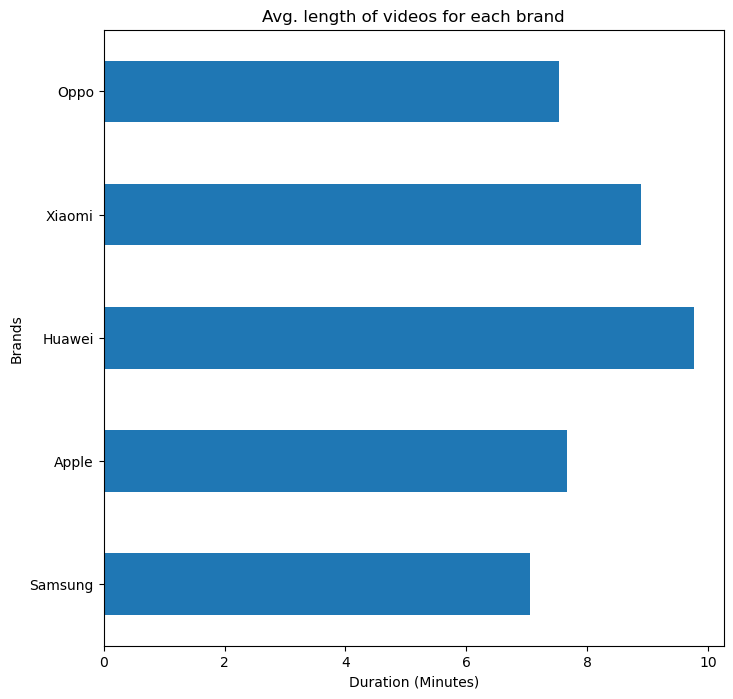

In [111]:
stats_brand_df.average_duration_video.apply(lambda x: x/60).plot(kind="barh", 
                                                                 title="Avg. length of videos for each brand", 
                                                                 figsize=(8, 8), xlabel="Duration (Minutes)", 
                                                                 ylabel="Brands") 

The average duration of all the selected brands is almost the same: almost 7 minutes.
This is a bit surprising, we expected a bigger difference of the average duration of the videos for a specific brand over the selected brands.

Text(0, 0.5, '')

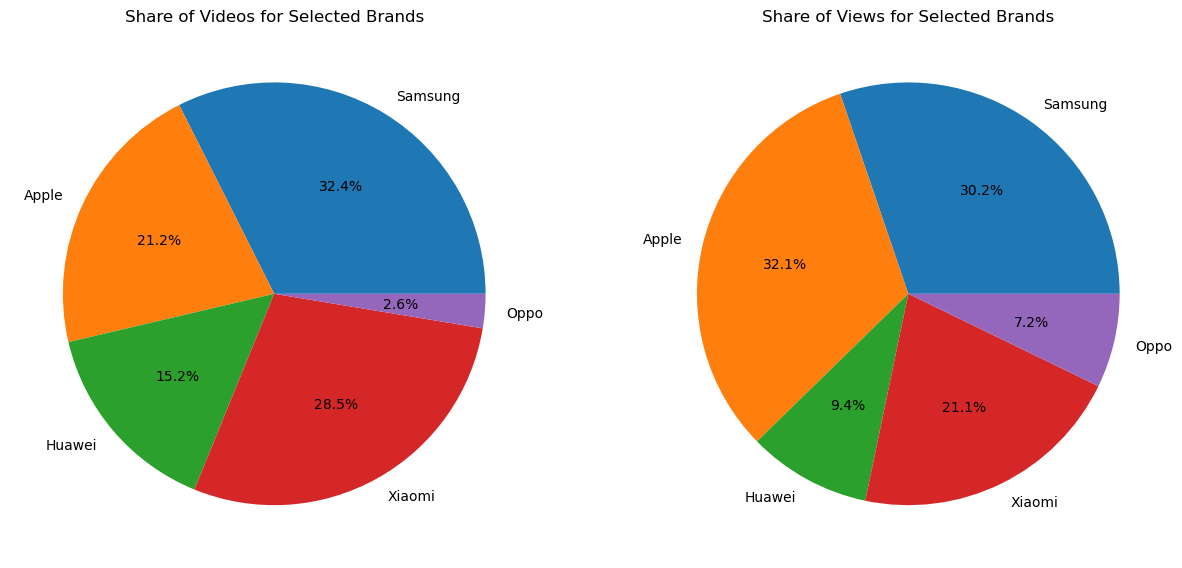

In [112]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

#          'average_views_video','nbr_channels_covering_brand'

stats_brand_df.number_videos.plot.pie(ax=ax1,legend=False, autopct='%1.1f%%')
stats_brand_df.total_views.plot.pie(ax=ax2,legend=False, autopct='%1.1f%%')
ax1.set_title("Share of Videos for Selected Brands")
ax2.set_title("Share of Views for Selected Brands")
ax1.set_ylabel(None)
ax2.set_ylabel(None)

In this figure, we plot two pie charts. The first one illustrates the number of videos made about each brand and the second one the total views of each brands. Both are taken over the whole time span of the data.  
Samsung clearly dominates the share of videos made about their models in comparison to the other brands with over 40% as well as the share of the total number of views with almost 40%.  
Apple has only 11% for the share of videos made about their models, however it has almost doubled this value concerning the share of total number of views (21.8%).  
Oppo has only 6.9% for the share of videos made about their models, however it has almost doubled this value concerning the share of total number of views (11.9%).  
These pieplots means that Apple and Oppo videos interests more viewers compared to the other brands. In particular, even though Samsung has more videos made about their products, a video
made about an apple product will, on average, get more views.

Text(0, 0.5, 'No. of Channels')

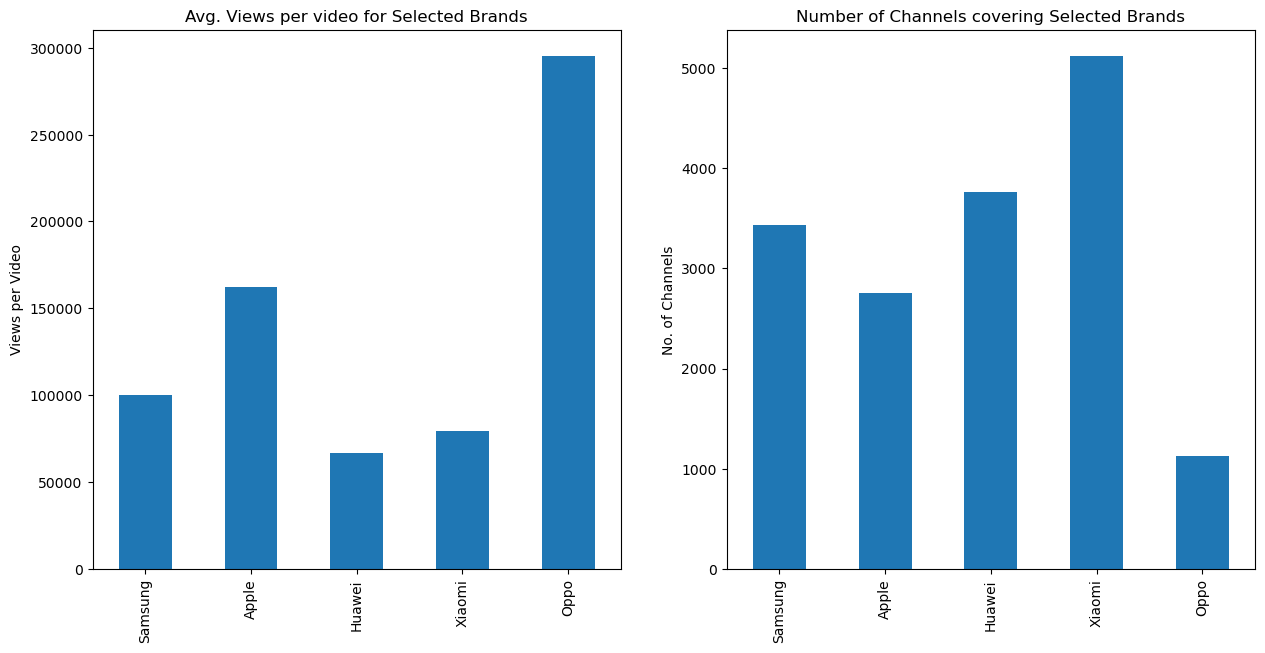

In [113]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

stats_brand_df.average_views_video.plot.bar(ax=ax1)
stats_brand_df.nbr_channels_covering_brand.plot.bar(ax=ax2)
ax1.set_title("Avg. Views per video for Selected Brands")
ax2.set_title("Number of Channels covering Selected Brands")
ax1.set_ylabel("Views per Video")
ax2.set_ylabel("No. of Channels")

The first plot confirms the analysis of the plots above concerning the fact that Apple and Oppo get significantly more views per videos with around 200'000 views per video for each one of them.  
Even if Samsung dominates the number of videos and total videos, it has only a bit more than 100'000 which around 50% of of Apples's average views per video.

The second plot shows that Samung has the most channels covering its devices. However, we have less variation compared the share of views or videos of the selected brands.

Text(0, 0.5, 'No. of Dislikes')

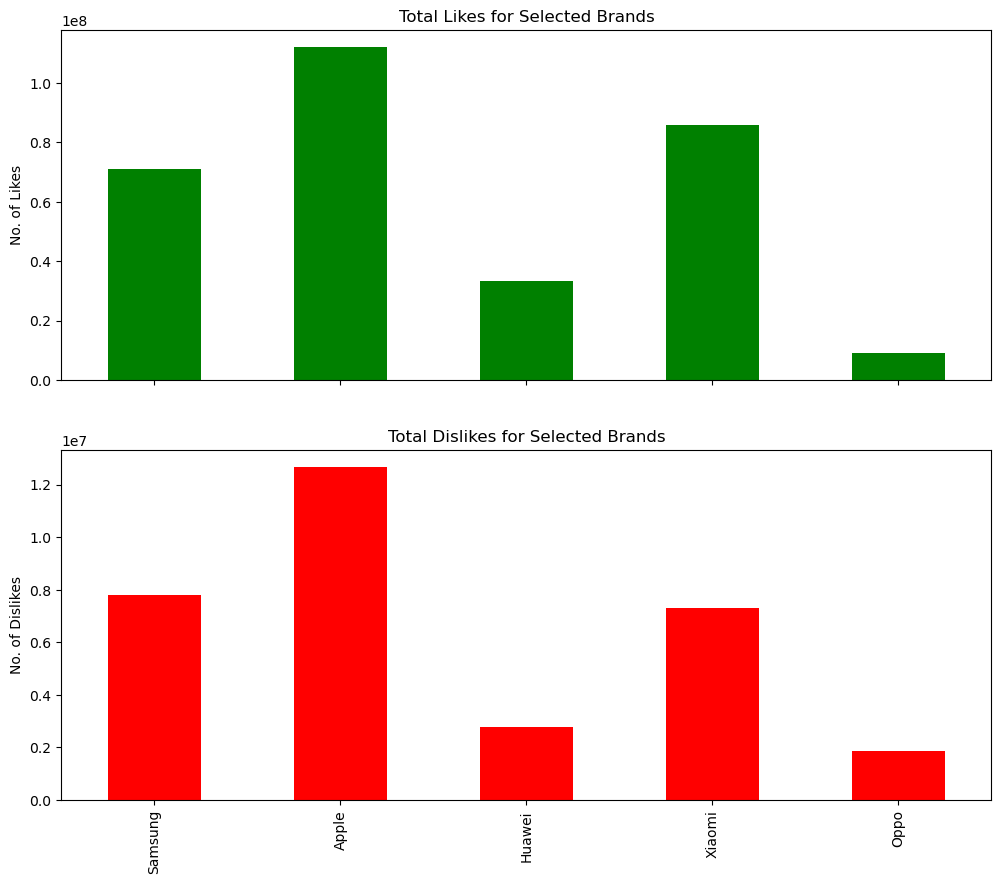

In [114]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

stats_brand_df.nbr_likes.plot.bar(ax=ax1, color="green")
stats_brand_df.nbr_dislikes.plot.bar(ax=ax2, color="red")
ax1.set_title("Total Likes for Selected Brands")
ax2.set_title("Total Dislikes for Selected Brands")
ax1.set_ylabel("No. of Likes")
ax2.set_ylabel("No. of Dislikes")

Here we notice immediatly that the ratios between likes and dislikes is approximately the same for each brand. This is surprising as we thought that some brands, like Apple, had more dedicated fans which would like their videos more than they get disliked.  
We also notice that the number of likes is, on average, approximately equal to ten times the number of dislikes. Consequently, for each dislike a video gets, it will get ten likes on average.

Text(0, 0.5, 'Avg Dislikes per Video')

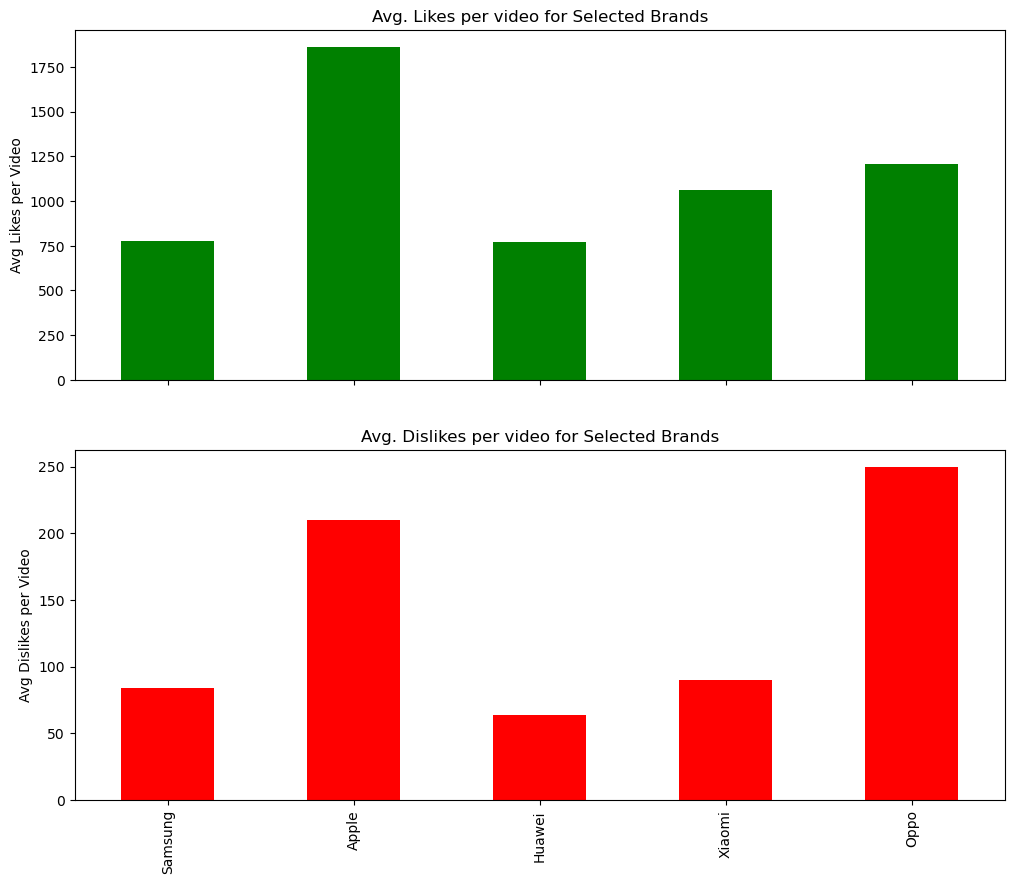

In [115]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

stats_brand_df.average_like_video.plot.bar(ax=ax1, color="green")
stats_brand_df.average_dislike_video.plot.bar(ax=ax2, color="red")
ax1.set_title("Avg. Likes per video for Selected Brands")
ax2.set_title("Avg. Dislikes per video for Selected Brands")
ax1.set_ylabel("Avg Likes per Video")
ax2.set_ylabel("Avg Dislikes per Video")

The same comments as for the preceeding graph apply.  
We notice immediatly that the ratios between likes and dislikes is approximately the same for each brand. This is surprising as we thought that some brands, like Apple, had more dedicated fans which would like their videos more than they get disliked.

Text(0, 0.5, '% Dislikes per viewer')

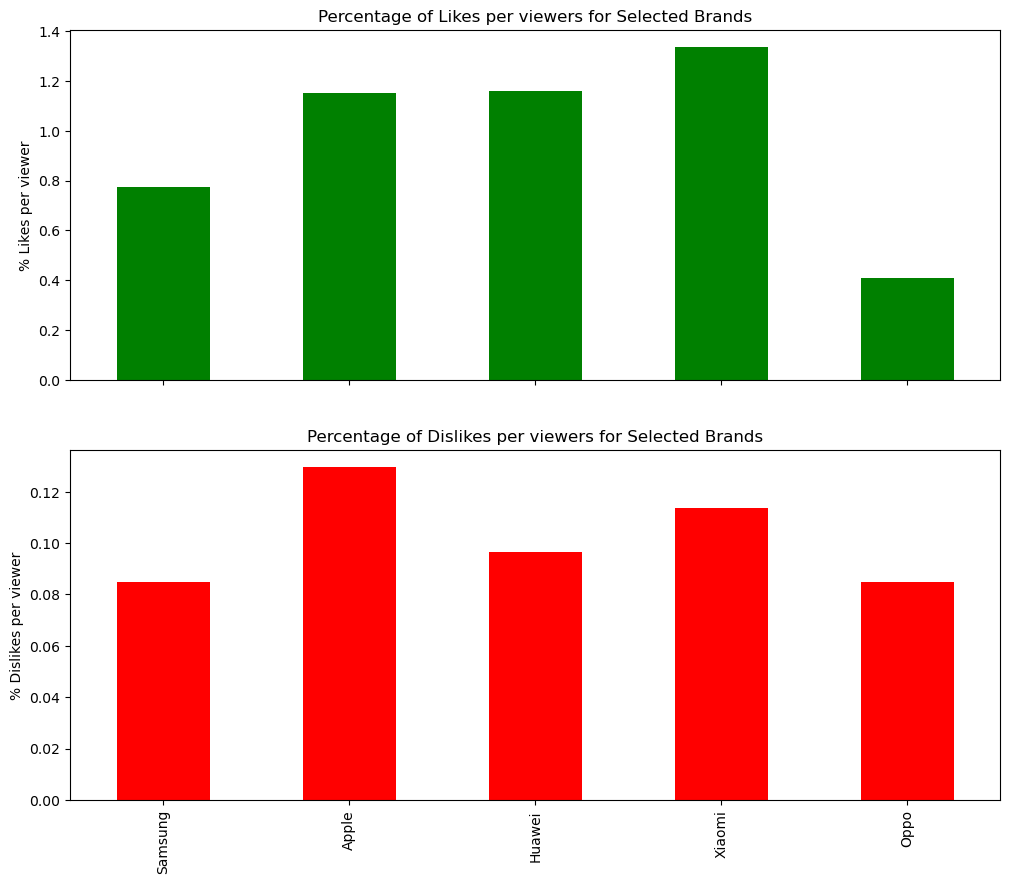

In [116]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

stats_brand_df.percentage_like_per_viewer.plot.bar(ax=ax1, color="green")
stats_brand_df.percentage_dislike_per_viewer.plot.bar(ax=ax2, color="red")
ax1.set_title("Percentage of Likes per viewers for Selected Brands")
ax2.set_title("Percentage of Dislikes per viewers for Selected Brands")
ax1.set_ylabel("% Likes per viewer")
ax2.set_ylabel("% Dislikes per viewer")


These graphs shows the percentage of viewers, among those that watch videos of a given brand, that like or dislike videos.  
We observe that the percentage does not vary a lot between brands both for likes and dislikes. In general, only a small percentage of viewers like or dislike videos. Indeed, on average, across all brands, only one viewer in a thousand will dislike a video and only one in a hundred will like a video.

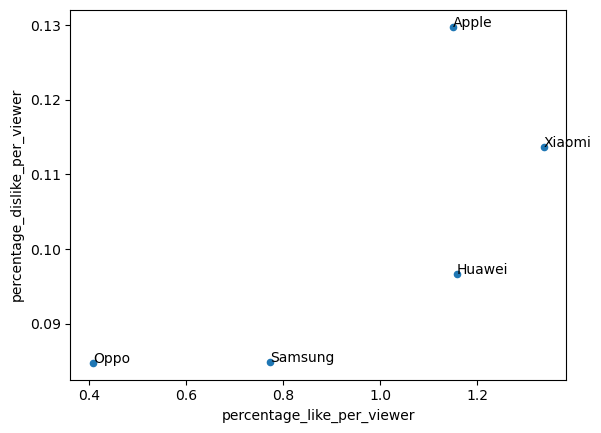

In [117]:
plot = stats_brand_df.plot.scatter(x='percentage_like_per_viewer',
                                  y='percentage_dislike_per_viewer')
for i in range(len(stats_brand_df)):
    plot.annotate(str(stats_brand_df.index[i]),(stats_brand_df.percentage_like_per_viewer[i], 
                                               stats_brand_df.percentage_dislike_per_viewer[i]))

Surprisingly, It is not the most popular brands such as Apple or Samsung that are the most liked or hated per viewer. It is Xiaomi that has the most percentage of likes per viewer which is a good metric performance for them. However, they have also the most dislike ratio per viewer. We notice, that viewers like to interact witch Xiaomi videos. Furthermore, we can see that there seems to exists a linear relationship between the percentage of like and dislike per viewer.

Text(0, 0.5, 'Views per device')

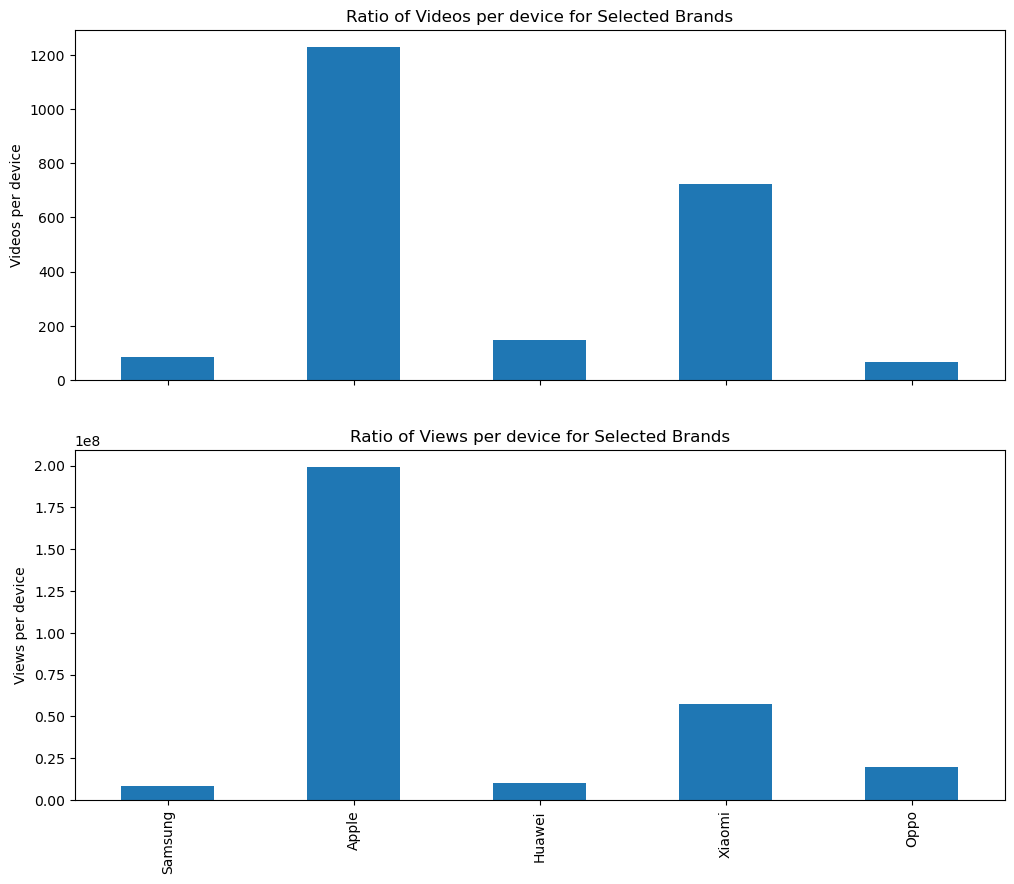

In [118]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

stats_brand_df.nbr_videos_per_product.plot.bar(ax=ax1)
stats_brand_df.nbr_views_per_product.plot.bar(ax=ax2)
ax1.set_title("Ratio of Videos per device for Selected Brands")
ax2.set_title("Ratio of Views per device for Selected Brands")
ax1.set_ylabel("Videos per device")
ax2.set_ylabel("Views per device")


We see that Apple dominates both the number of vides per device as well as the number of views per device. This is related to the fact that it has the least number of models among all the brands we consider here and to the fact that it is one of the most popular brands in terms of total number of views.

## Timeseries Visualizations

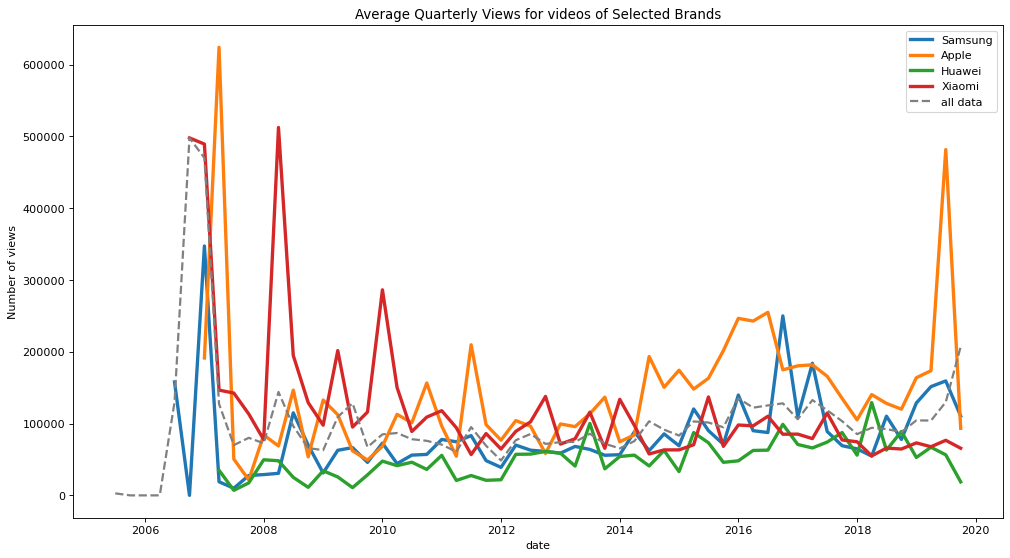

In [119]:
get_plot(BRANDS_TO_ANALYZE, "view_count", "mean", 
         videos_by_brand_exclusive, figsize=(15, 8), y_label="Number of views", x_label="date", 
         title="Average Quarterly Views for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos) 

We observe that Apple dominates all other brands during the whole timeline. Notice however that this average is taken quaterly. Having few videos with a large number of views per videos, like Apple does, increases the average number of views. This does not mean that the total number of views of Apple is larger, as we will se bellow.  
We also notice that the average number of views of Apple videos seems to increase more than that of the other brands with respect to time which might indicate that the brand got more popular over time.  
Furthermore, we notice the existance of a peak in average number of views per quarter in late 2016 for all brands but particularly for Apple. It would be interesting to investigate further why this peak suddently happended.

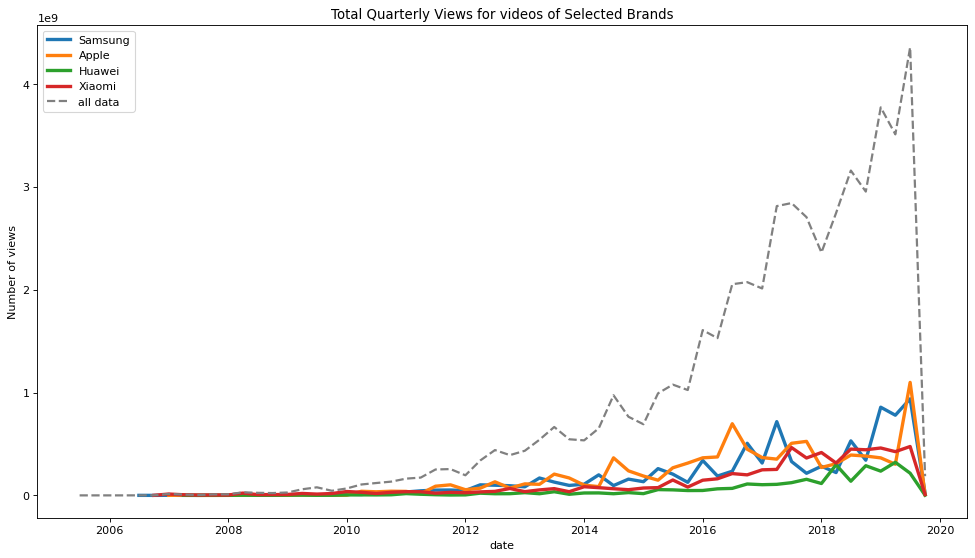

In [120]:
get_plot(BRANDS_TO_ANALYZE, "view_count", "sum", 
         videos_by_brand_exclusive, figsize=(15, 8), y_label="Number of views", x_label="date", 
         title="Total Quarterly Views for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos) 

This plot has to be interpreted in the light of the previous one. We see that Samsung has a larger average number of views per quarter than Apple. This is the case because, as shown before, the number of views per video of Samsung is lower than that of Apple but its number of videos is larger. Consequently if we take a quaterly average on the number of views over Apple videos, the average will be large (few videos, a lot of views per videos) whereas the same average over Samsung videos will be low (a lot of videos, less views per video) even though in absolute number Samsung still dominates in term of number of views.

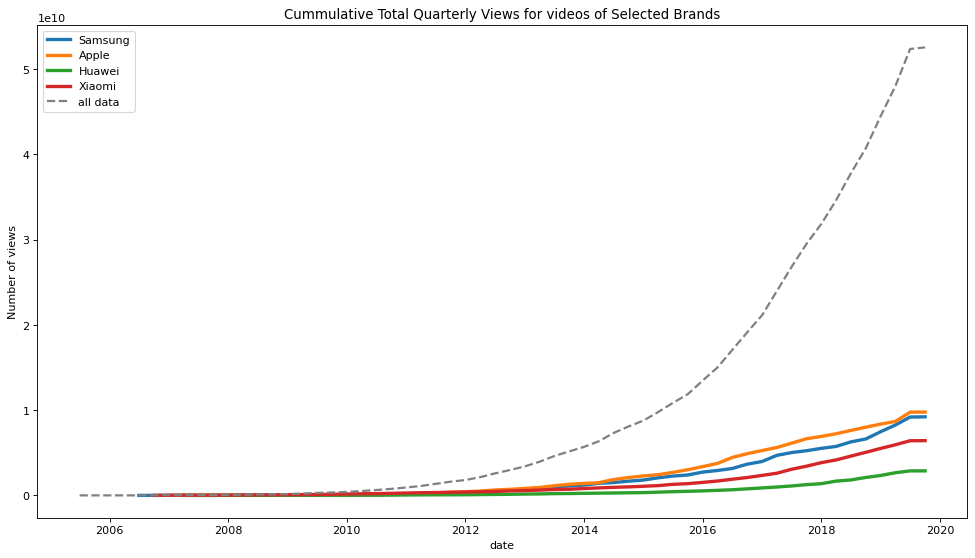

In [121]:
get_plot_cummulative(BRANDS_TO_ANALYZE, "view_count", "sum", 
         videos_by_brand_exclusive, figsize=(15, 8), y_label="Number of views", x_label="date", 
         title="Cummulative Total Quarterly Views for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos) 

This plot allows us to see more clearly the trends discussed under the preceeding plot.  
We see that towards the end Xiaomi and Huawei surpass LG in terms of cumulated number of views.

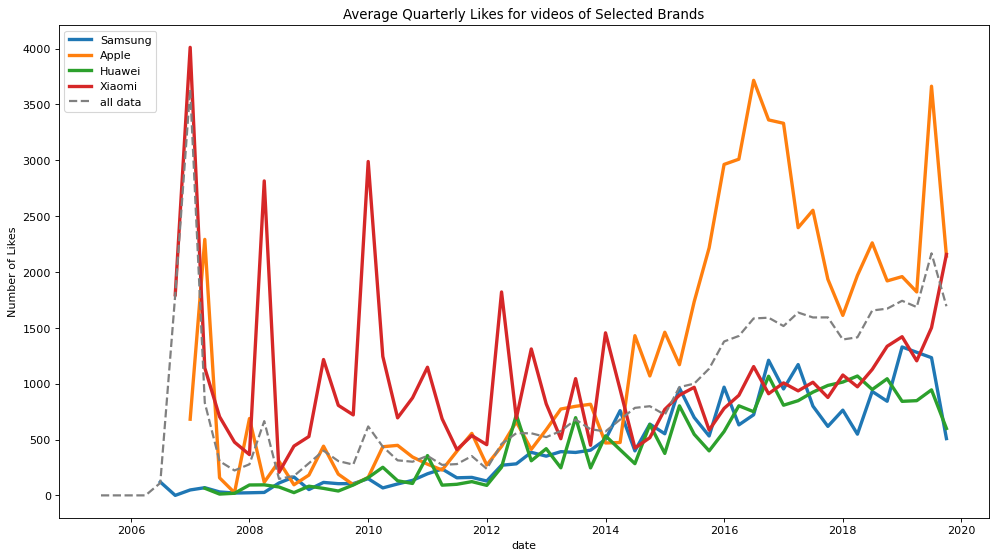

In [122]:
get_plot(BRANDS_TO_ANALYZE, "like_count", "mean", 
         videos_by_brand_exclusive, figsize=(15, 8), y_label="Number of Likes", x_label="date", 
         title="Average Quarterly Likes for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos)

We see that the spike seen with respect to the number of views is also visible here when discussing the number of likes. This makes sense as more views should generate more likes.

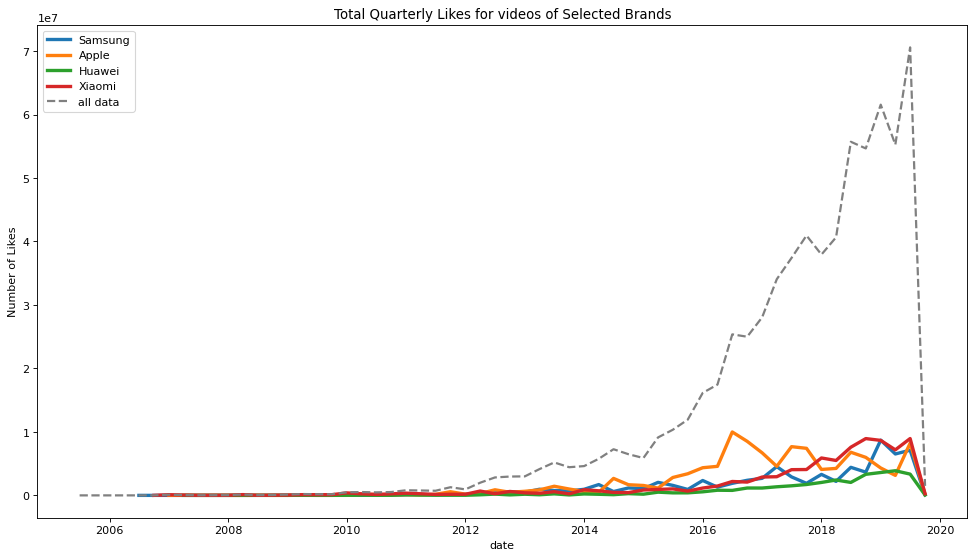

In [123]:
get_plot(BRANDS_TO_ANALYZE, "like_count", "sum", 
         videos_by_brand_exclusive, figsize=(15, 8), y_label="Number of Likes", x_label="date", 
         title="Total Quarterly Likes for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos)

This plot has to be interpreted in the light of the previous one. We see that Samsung has a larger average number of likes per quarter than Apple. This is the case because, as shown before, the number of likes per video of Samsung is lower than that of Apple but its number of videos is larger. Consequently if we take a quaterly average on the number of likes over Apple videos, the average will be large (few videos, a lot of likes per videos) whereas the same average over Samsung videos will be low (a lot of videos, less likes per video) even though in absolute number Samsung still dominates in term of number of likes. Consequently, the spike seen in the preceeding graph is smaller on this one.

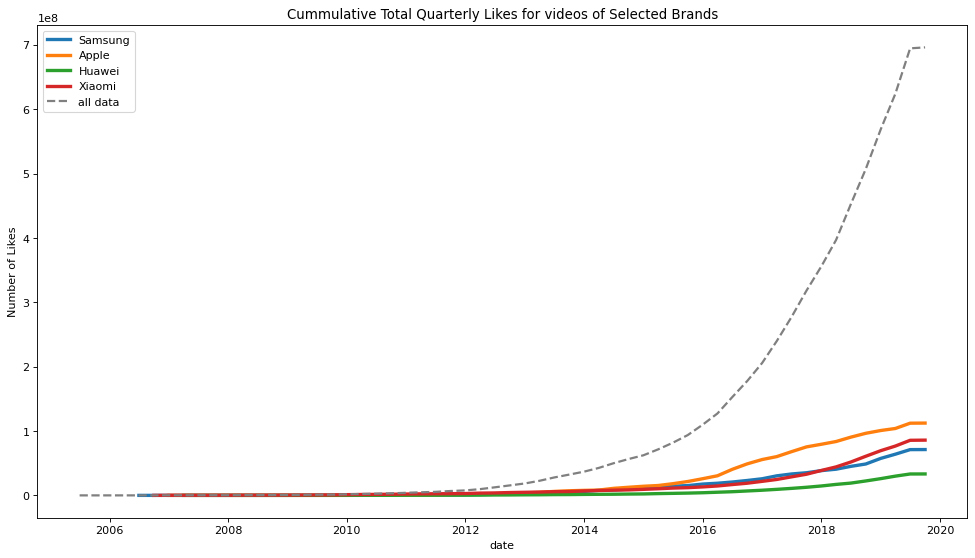

In [124]:
get_plot_cummulative(BRANDS_TO_ANALYZE, "like_count", "sum", 
         videos_by_brand_exclusive, figsize=(15, 8), y_label="Number of Likes", x_label="date", 
         title="Cummulative Total Quarterly Likes for videos of Selected Brands", 
         interval="QS", whole_data=branded_videos)

This plot allows us to see more clearly the trends discussed under the preceeding plot.  
We see that towards the end Xiaomi and Huawei surpass LG in terms of cumulated number of likes.

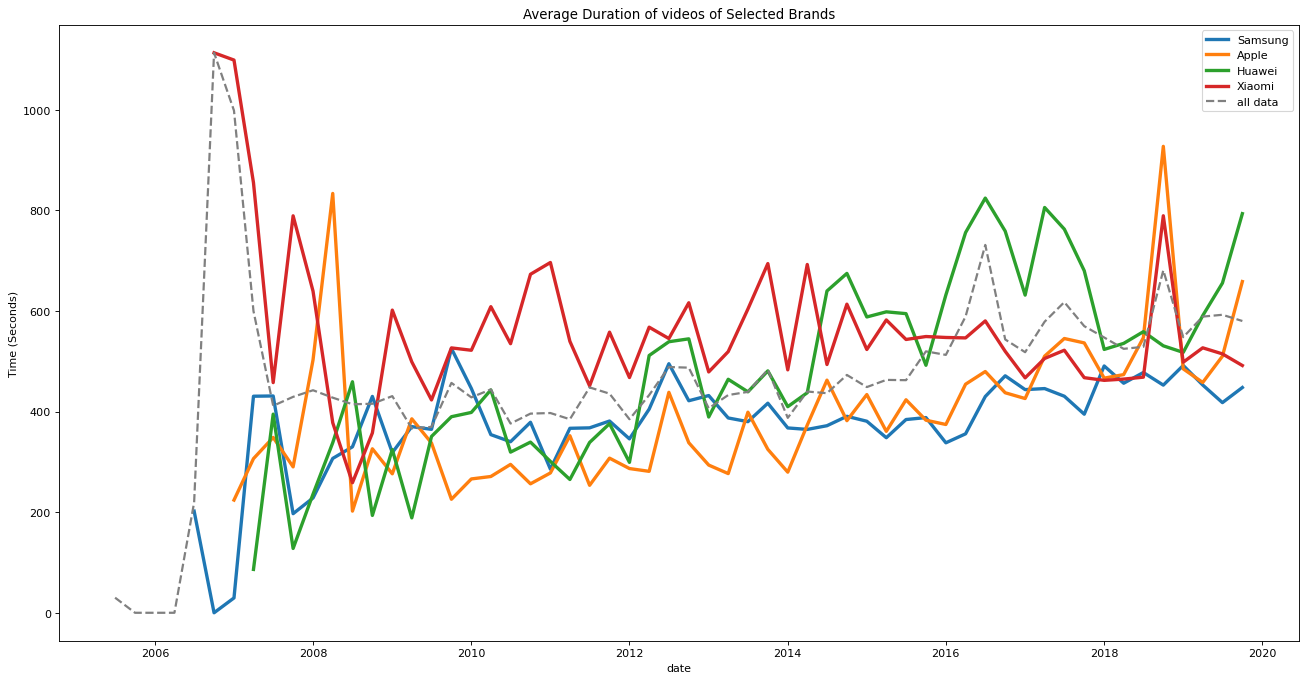

In [125]:
get_plot(BRANDS_TO_ANALYZE, "duration", "mean", 
         videos_by_brand_exclusive, figsize=(20, 10), y_label="Time (Seconds)", x_label="date", 
         title="Average Duration of videos of Selected Brands", 
         interval="QS", whole_data=branded_videos)

Overall the average duration seems to be increasing slightly. Furthermore, we notice a huge spike in length for Apple around 2008. This might have a link with the fact that the first Iphone was released in 2007, only a few months before.

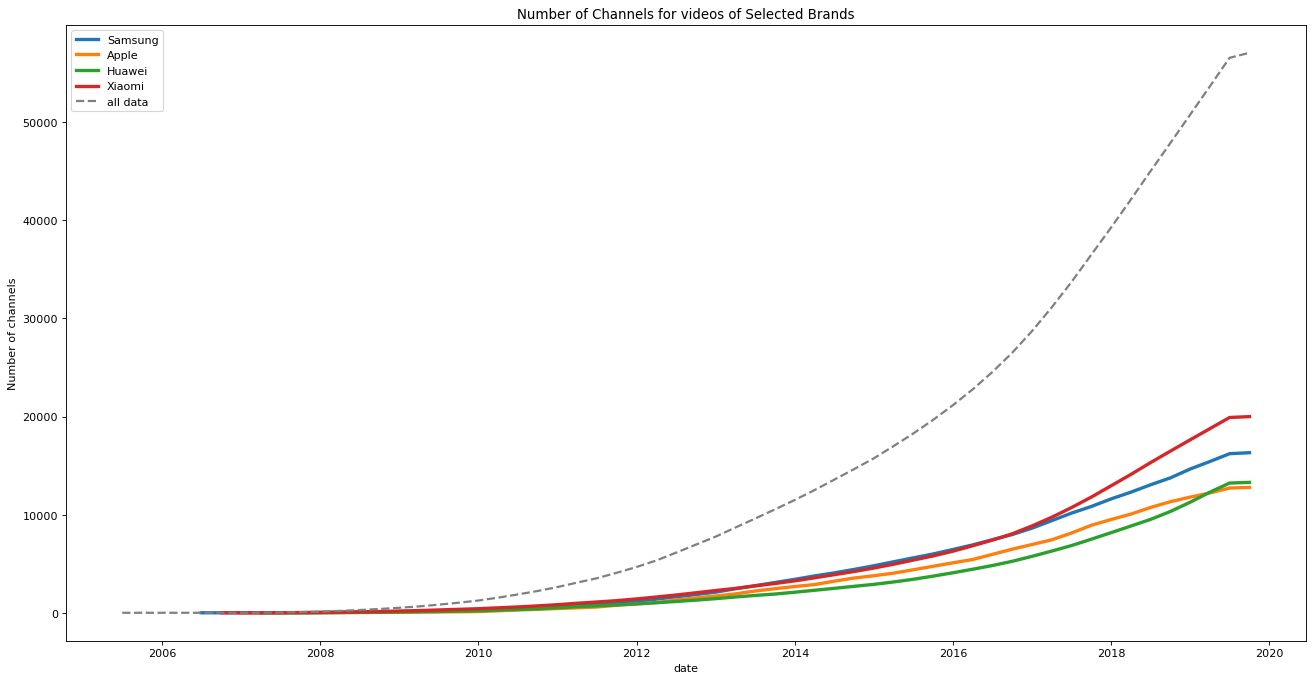

In [126]:
get_plot_cummulative(BRANDS_TO_ANALYZE, "channel_id", "nunique", 
         videos_by_brand_exclusive, y_label="Number of channels", x_label="date", 
         title="Number of Channels for videos of Selected Brands", 
         interval="QS",  whole_data=branded_videos)

We observe here that Samsung is the brand with the largest number of channels making videos about its products. We also notice that the gap between Samsung and the other brands is big and that the other brands are all close in term of number of channels talking about their products. The fact that Samsung has more channels is not surprising given that we knew before that the number of videos related to this brand was the largest among the brands considered.

## Text Analysis

### Process Words in titles and descriptions

In [127]:
# Group titles of videos for each brands in a long string for each of the brands
title_words = {}

for brand in BRANDS_TO_ANALYZE:
    titles = videos_by_brand_exclusive[brand].title
    words = ""
    for index, title in titles.items():
        words += title + " "  
        
    title_words[brand] = words

In [128]:
# Group descriptions of videos for each brands in a long string for each of the brands
description_words = {}

for brand in BRANDS_TO_ANALYZE:
    descriptions = videos_by_brand_exclusive[brand].description
    words = ""
    for index, description in descriptions.items():
        words += title + " "    
    description_words[brand] = words

### Calculate the most used words for each brand

Here we have analyzed how the coverage of different brands is in terms of the titles of videos. We do this by observing the most used words for the titles of videos.

In [179]:
useless_words = STOPWORDS.union(set(string.punctuation)).union(set(string.whitespace))

In [202]:
# Take only 1000 most occuring words in each case

common_words_count = {}
common_adjectives_count = {}
common_words_avg = {}
common_adjectives_avg = {}


for brand in BRANDS_TO_ANALYZE:
    # split words in all titles
    words = re.split(r"(\b[^\s]+\b)|^([^\s\w])", title_words[brand]) # + " " + description_words[brand])
    
    cleaned_words = []
    # Remove Stopwords, punctuations and whitespace
    for word in words:
        if word and word.lower() not in useless_words and " " not in word:
            try:
                int(word)
            except ValueError:
                cleaned_words.append(word.capitalize())
    
    # Group words by Frequency
    word_counts = Counter(cleaned_words)
    common_words_count[brand] = word_counts.most_common(1000)

    common_words_avg[brand] = [(word, count/len(cleaned_words)) for (word, count) in word_counts.most_common(1000)]
    
    # Find adjective words
    adjectives = []
    for word in cleaned_words:
        # Check if it is present as a verb in NLTK Corpus
        if wn.synsets(word, pos=wn.ADV):
            adjectives.append(word)
            
    adj_counts = Counter(adjectives)
    common_adjectives_count[brand] = adj_counts.most_common(1000)
    common_adjectives_avg[brand] = [(word, count/len(cleaned_words)) for (word, count) in adj_counts.most_common(1000)]

In [203]:
word_counts.most_common(10)

[('Oppo', 5272),
 ('Pro', 1277),
 ('Vs', 1255),
 ('Comparison', 848),
 ('Review', 791),
 ('Camera', 751),
 ('Unboxing', 737),
 ('Realme', 693),
 ('One', 600),
 ('Vivo', 538)]

In [204]:
common_words_count["Apple"][:10]

[('Iphone', 41752),
 ('Ios', 13916),
 ('Apple', 7981),
 ('Review', 7401),
 ('Vs', 6084),
 ('Plus', 5485),
 ('Case', 4578),
 ('New', 4508),
 ('X', 3753),
 ('Jailbreak', 3725)]

In [205]:
common_words_avg["Apple"][:10]

[('Iphone', 0.10377602354297985),
 ('Ios', 0.03458869380207194),
 ('Apple', 0.019837048378437493),
 ('Review', 0.018395438547652663),
 ('Vs', 0.015121990018094689),
 ('Plus', 0.013633155037680698),
 ('Case', 0.011378775526436142),
 ('New', 0.011204788133065559),
 ('X', 0.009328209818854268),
 ('Jailbreak', 0.009258614861506035)]

### Analyze Common Words

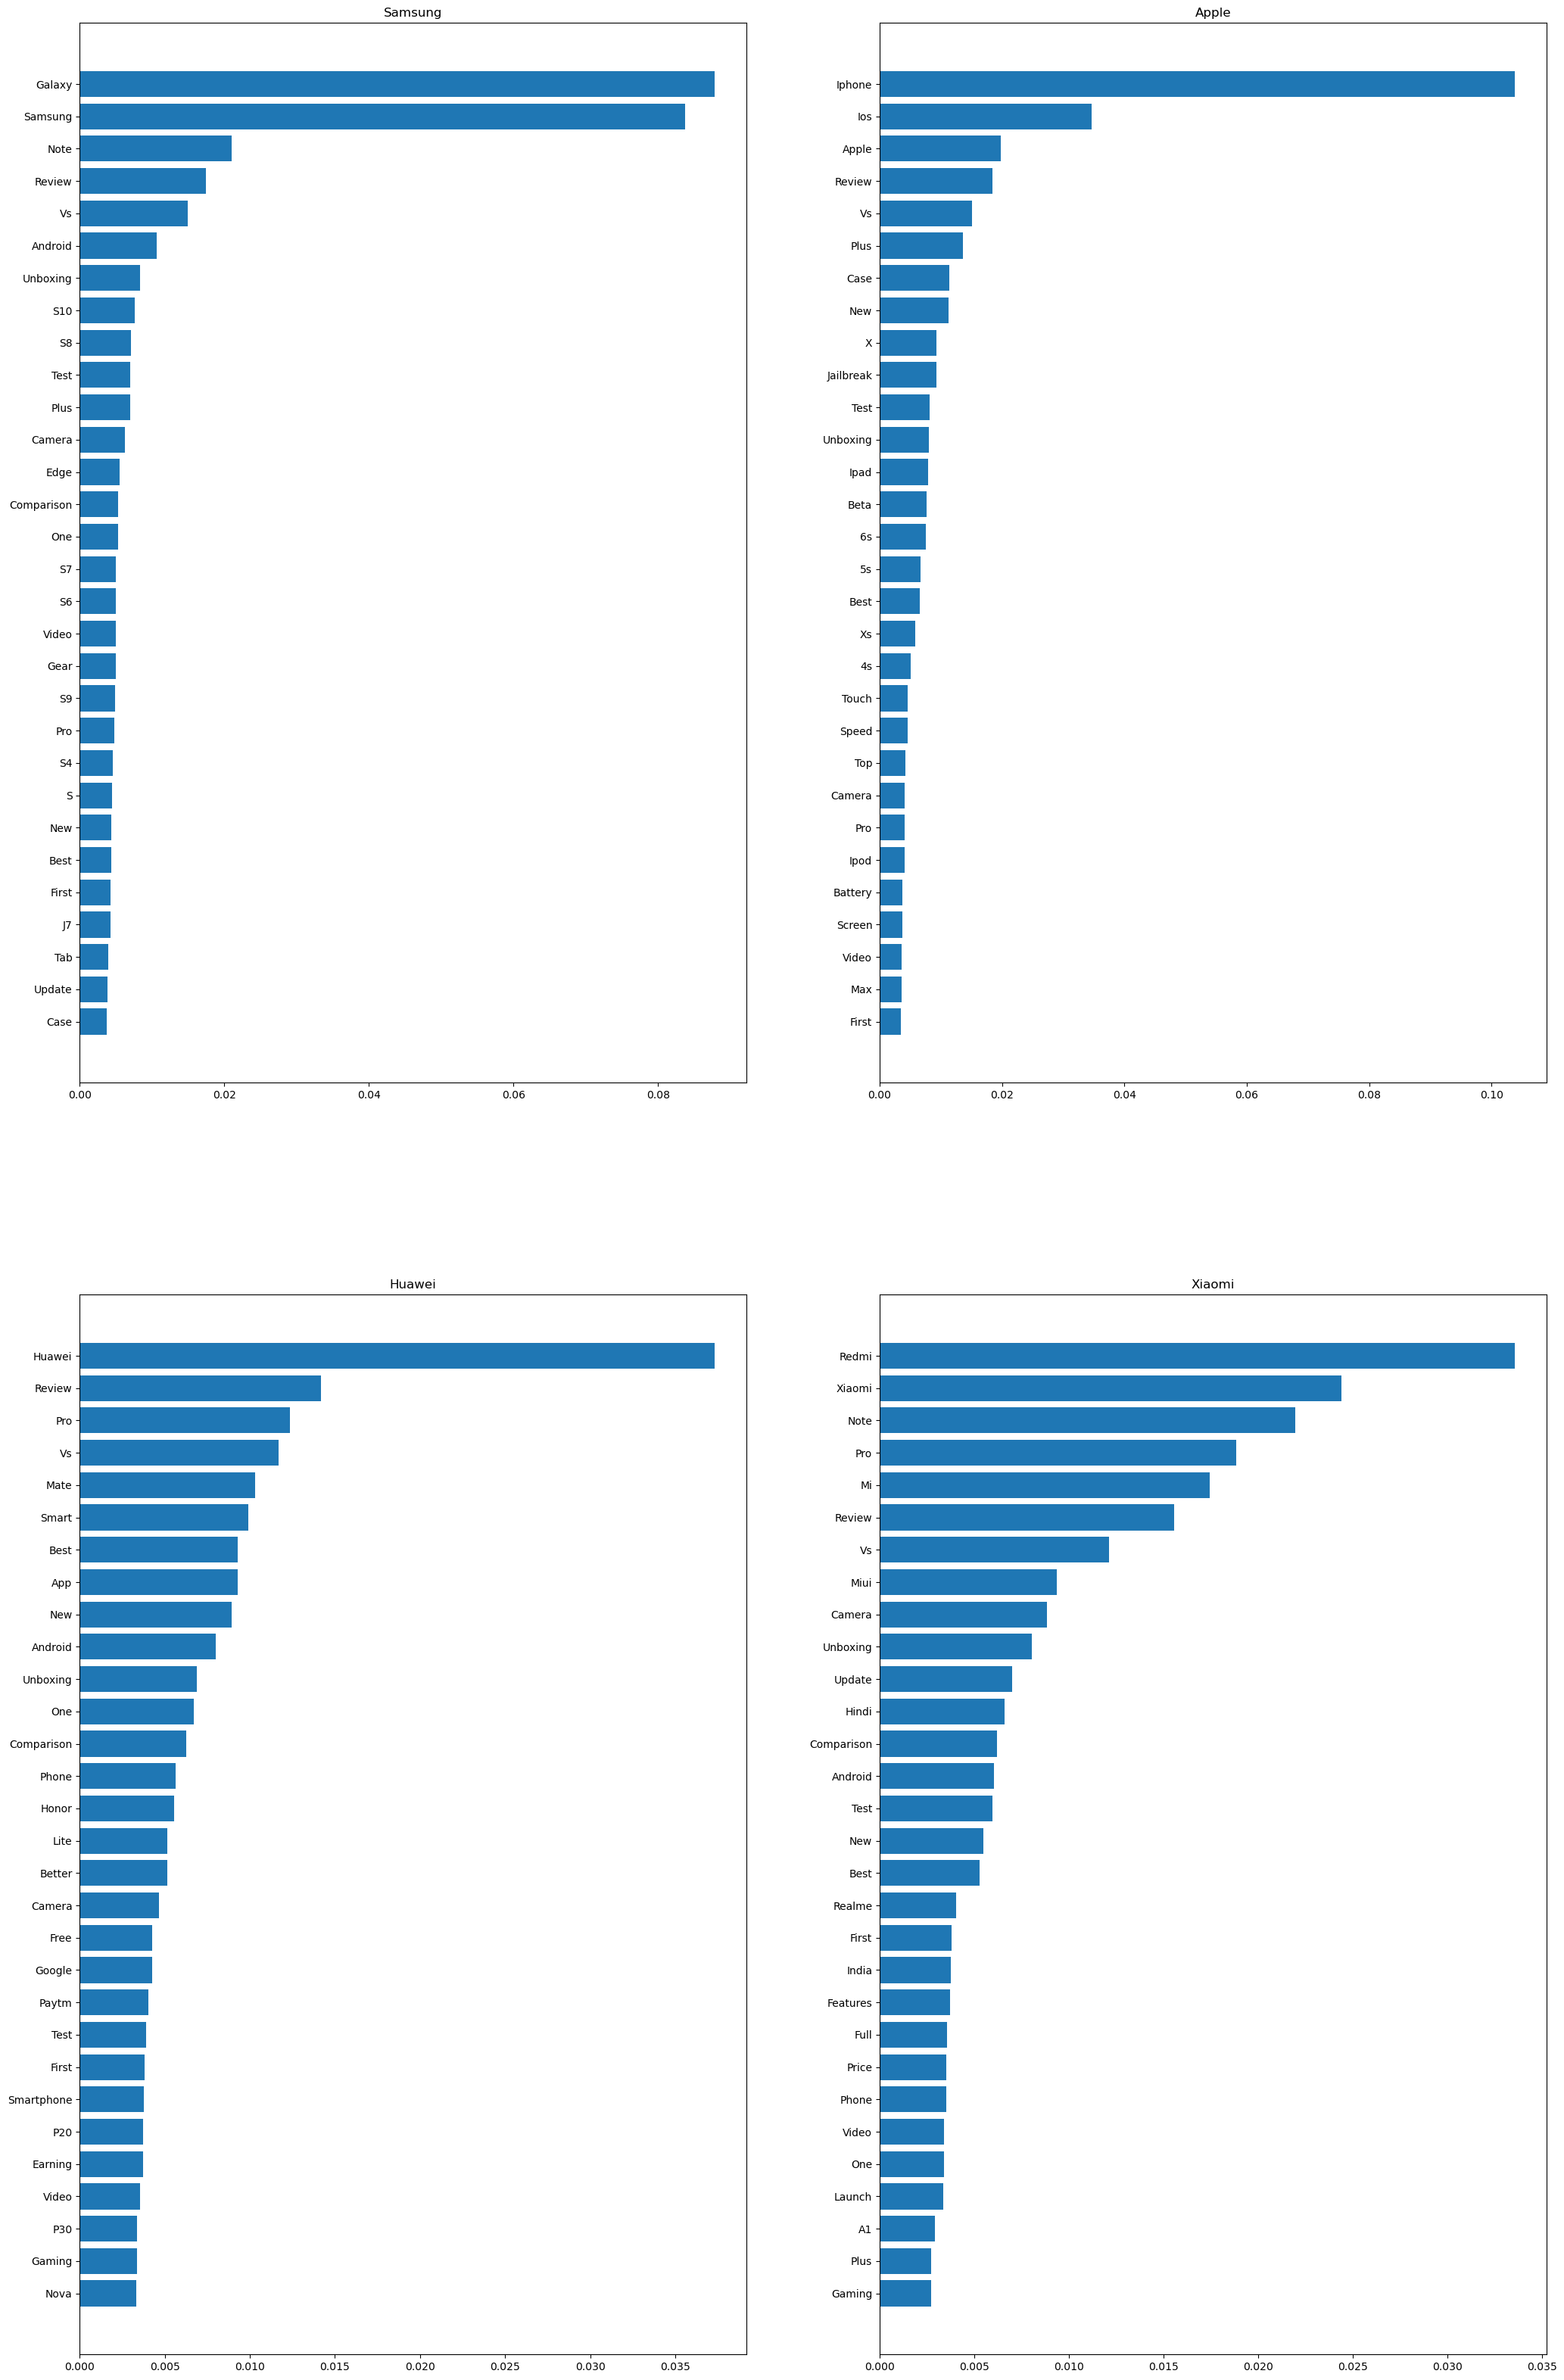

In [206]:
fig, axs = plt.subplots(nrows=2, ncols=len(BRANDS_TO_ANALYZE)//2, figsize=(25, 40))


for ax, brand in zip(axs[0,:], BRANDS_TO_ANALYZE[:len(BRANDS_TO_ANALYZE)//2]):
    x = [tag for tag, count in common_words_avg[brand][:30]]
    y = [count for tag, count in common_words_avg[brand][:30]]
    x.reverse()
    y.reverse()
    ax.barh(x, y)
    ax.set_title(brand)


for ax, brand in zip(axs[1,:], BRANDS_TO_ANALYZE[len(BRANDS_TO_ANALYZE)//2:]):
    x = [tag for tag, count in common_words_avg[brand][:30]]
    y = [count for tag, count in common_words_avg[brand][:30]]
    x.reverse()
    y.reverse()
    ax.barh(x, y)
    ax.set_title(brand)

Here we can see that the most common words used to describe the methods are very similar to each other with almost the same words appearing in all the titles. This can be partially due to the fact that the coverage is similar but also that there are about comparisons between phones. This can mask the variety among the titles as the videos will appear for the multiple brands. This fact is also evident from the fact that competitor brands and their model names make up for most used words in titles of videos for each company.

This observation needs to be studied in more detail by seperating the comparison videos using keyword search and videos that appear for more than one brand.

### Analyze Common Adjectives

In [207]:
go_fig = go.Figure()
for brand in BRANDS_TO_ANALYZE:
    x = [tag for tag, count in common_adjectives_count[brand][:20]]
    y = [count for tag, count in common_adjectives_count[brand][:20]]
    go_fig.add_trace(go.Bar(
        x=x,
        y=y,
        name=brand,
    ))

go_fig.update_layout(barmode='group', xaxis_tickangle=-45, xaxis={'categoryorder':'total descending'})
go_fig.update_yaxes(type="log")
go_fig.show()

In [210]:
go_fig = go.Figure()
for brand in BRANDS_TO_ANALYZE:
    x = [tag for tag, count in common_adjectives_avg[brand][:20]]
    y = [count for tag, count in common_adjectives_avg[brand][:20]]
    go_fig.add_trace(go.Bar(
        x=x,
        y=y,
        name=brand,
    ))

go_fig.update_layout(barmode='group', xaxis_tickangle=-45, xaxis={'categoryorder':'total descending'})
# go_fig.update_yaxes(type="log")
go_fig.show()

In [178]:
go_fig = go.Figure()
for brand in BRANDS_TO_ANALYZE:
    x = [tag for tag, count in common_adjectives[brand][:10]]
    y = [count for tag, count in common_adjectives[brand][:10]]
    y = [y/len(videos_by_brand_exclusive[brand]) for y in y]
    go_fig.add_trace(go.Bar(
        x=x,
        y=y,
        name=brand,
    ))

go_fig.update_layout(barmode='group', xaxis_tickangle=-45, xaxis={'categoryorder':'total descending'})
# go_fig.update_yaxes(type="log")
go_fig.show()

Similar to the most common words, the most common adjectives are also very similar between the brands. This also needs to be studied by isolating the videos that talk about only one brand.

## Create Word Clouds : Just for fun

This is a more fun way to show the textual analysis results.

#### For Apple

In [133]:
img = Image.open(os.path.join(BASE_PATH, IMAGES_FOLDER, "Apple Logo.png"))
img_invert = ImageOps.grayscale(img)
apple_mask = np.array(img_invert)

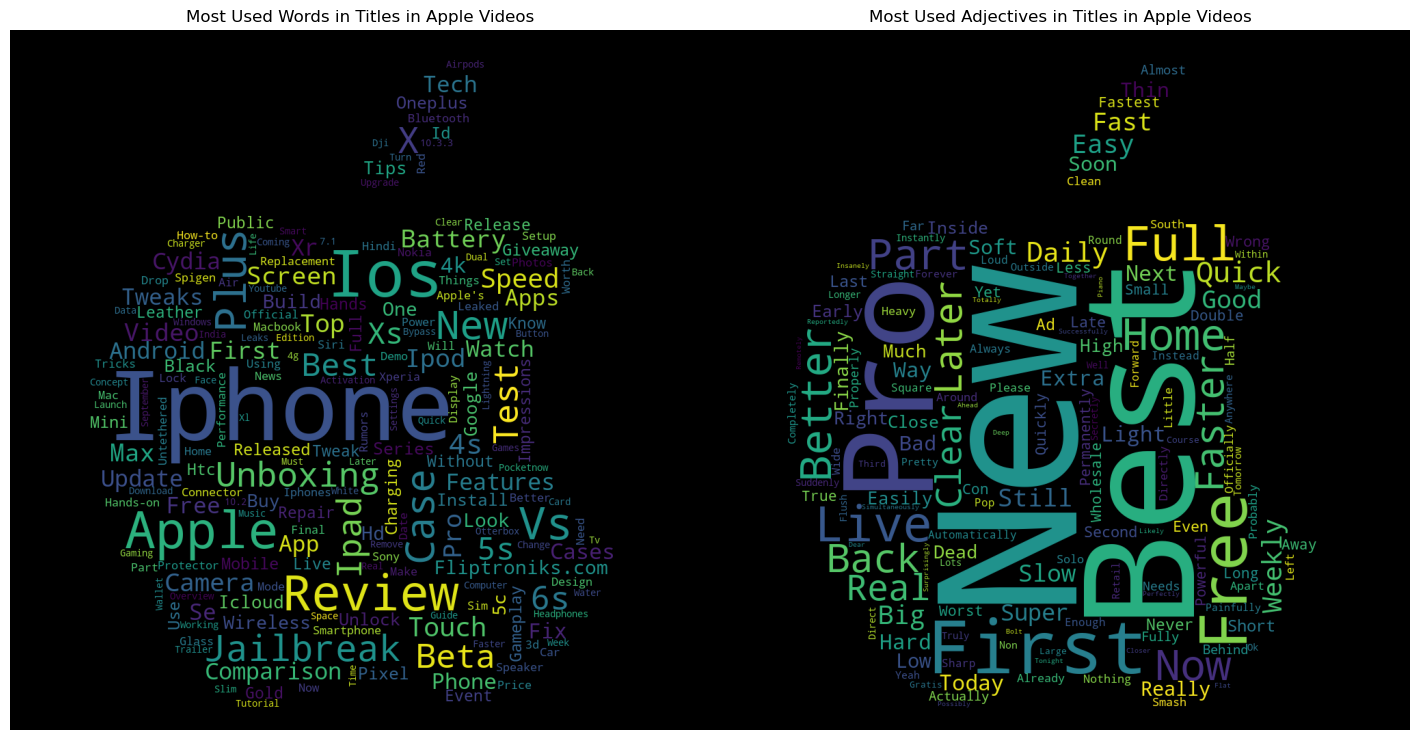

In [134]:
wordcloud = WordCloud(
                background_color ='black',
                min_font_size = 10,
                mask=apple_mask,
                contour_width=3, contour_color='black', random_state=2)

 
# plot the WordCloud image                      
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14, 7), facecolor = None)

ax1.imshow(wordcloud.generate_from_frequencies(dict(common_words["Apple"])))
ax1.set_title("Most Used Words in Titles in Apple Videos")
ax1.axis("off")
ax2.imshow(wordcloud.generate_from_frequencies(dict(common_adjectives["Apple"])))
ax2.set_title("Most Used Adjectives in Titles in Apple Videos")
ax2.axis("off")
plt.tight_layout(pad = 0)

#### For Samsung

In [135]:
img = Image.open(os.path.join(BASE_PATH, IMAGES_FOLDER, "Samsung Logo.jpeg"))
img_invert = ImageOps.grayscale(img)
samsung_mask = np.array(img_invert)

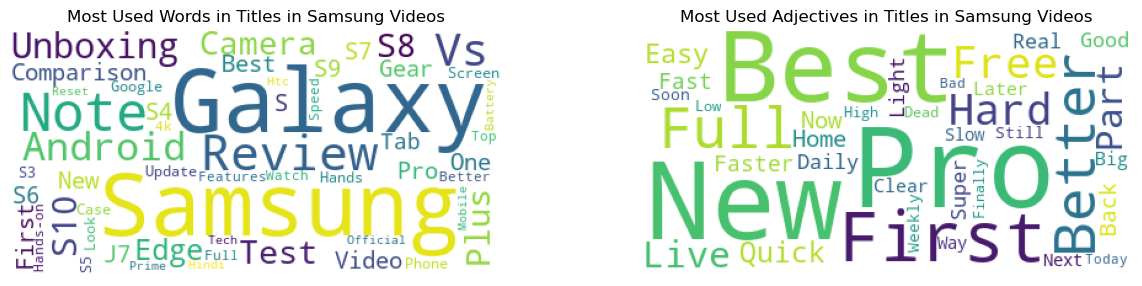

In [136]:
wordcloud = WordCloud(
                background_color ='white',
                min_font_size = 10,
#                 mask=samsung_mask,
                contour_width=0, contour_color='blue')
 
# plot the WordCloud image                      
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14, 7), facecolor = None)

ax1.imshow(wordcloud.generate_from_frequencies(dict(common_words["Samsung"])))
ax1.set_title("Most Used Words in Titles in Samsung Videos")
ax1.axis("off")
ax2.imshow(wordcloud.generate_from_frequencies(dict(common_adjectives["Samsung"])))
ax2.set_title("Most Used Adjectives in Titles in Samsung Videos")
ax2.axis("off")
plt.tight_layout(pad = 10)

#### For Huawei

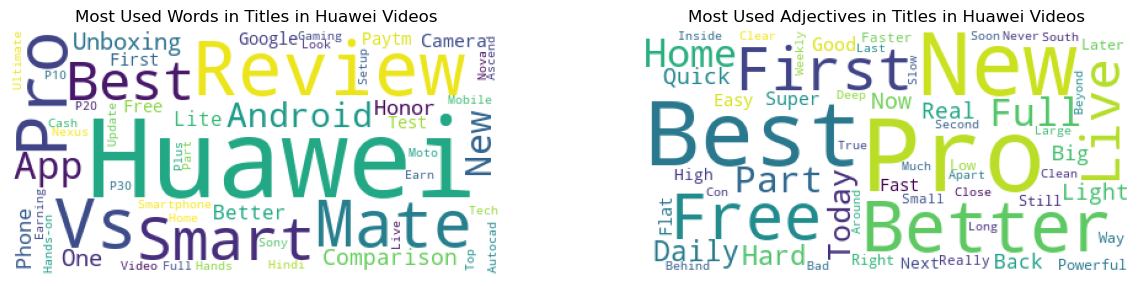

In [138]:
wordcloud = WordCloud(
                background_color ='white',
                min_font_size = 10,
#                 mask=samsung_mask,
                contour_width=0, contour_color='blue')
 
# plot the WordCloud image                      
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14, 7), facecolor = None)

ax1.imshow(wordcloud.generate_from_frequencies(dict(common_words["Huawei"])))
ax1.set_title("Most Used Words in Titles in Huawei Videos")
ax1.axis("off")
ax2.imshow(wordcloud.generate_from_frequencies(dict(common_adjectives["Huawei"])))
ax2.set_title("Most Used Adjectives in Titles in Huawei Videos")
ax2.axis("off")
plt.tight_layout(pad = 10)

#### For Xiaomi

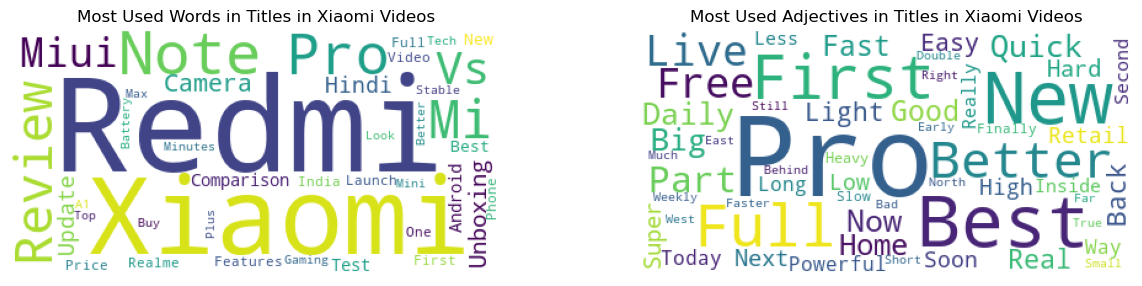

In [139]:
wordcloud = WordCloud(
                background_color ='white',
                min_font_size = 10,
#                 mask=samsung_mask,
                contour_width=0, contour_color='blue')
 
# plot the WordCloud image                      
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14, 7), facecolor = None)

ax1.imshow(wordcloud.generate_from_frequencies(dict(common_words["Xiaomi"])))
ax1.set_title("Most Used Words in Titles in Xiaomi Videos")
ax1.axis("off")
ax2.imshow(wordcloud.generate_from_frequencies(dict(common_adjectives["Xiaomi"])))
ax2.set_title("Most Used Adjectives in Titles in Xiaomi Videos")
ax2.axis("off")
plt.tight_layout(pad = 10)

#### For Oppo

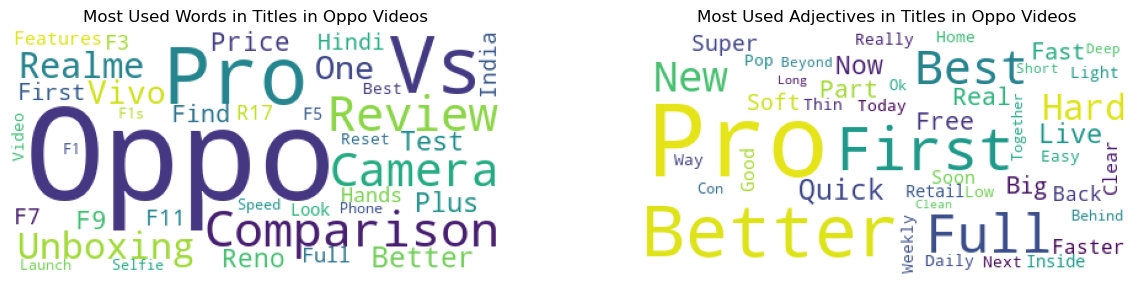

In [140]:
wordcloud = WordCloud(
                background_color ='white',
                min_font_size = 10,
#                 mask=samsung_mask,
                contour_width=0, contour_color='blue')
 
# plot the WordCloud image                      
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14, 7), facecolor = None)

ax1.imshow(wordcloud.generate_from_frequencies(dict(common_words["Oppo"])))
ax1.set_title("Most Used Words in Titles in Oppo Videos")
ax1.axis("off")
ax2.imshow(wordcloud.generate_from_frequencies(dict(common_adjectives["Oppo"])))
ax2.set_title("Most Used Adjectives in Titles in Oppo Videos")
ax2.axis("off")
plt.tight_layout(pad = 10)